<a href="https://colab.research.google.com/github/dhyannnn/2030-Assignments/blob/main/Exercise%2017%20-%20Rotation%20curves%20with%20priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Dhyan Thakkar__
<br>
Date: Feb. 14, 2022
<br>
PHYS 2030 W22

# <center><font color=#46769B>Exercise 17: Bayes theorem and fitting data</font></center>

## <font color=#46769B>Introduction</font>

In previous exercises, we fit rotation curve data using a theoretical model to determine the total mass of galaxes, including dark matter that could not be observed directly. 

Let's revisit the general problem of data fitting through the lens of Bayes theorem. 

Bayes theorem tells us that
$$P(A|B) = \frac{P(B|A) P(A)}{P(B)} \, .$$
Here we define $A,B$ as follows:
- $A$ represents our parameters. Let's simply denote our parameter as $A=x$. In general, $A$ represents all the parameters in our model, e.g., $A= x,y$ for our rotation curve example.
- $B = {\rm data}$ is the data (e.g., the circular velocity data).

Now, the probabilities entering Bayes theorem are:
- The __posterior PDF__ $P(A|B) = P(x|{\rm data})$ is the probability (density) of having a given parameter $x$ *given the data*. Given that the data is true, we want to know how likely it is to have $x$ be in a certain range.
- $P(B|A) = P({\rm data}|x)$ is the probability to fit the data *given a parameter $x$*. In the rotation curve example, we calculated this as
$$P({\rm data}|x) = e^{-\chi^2(x)/2} \, .$$
- $P(A) = P(x)$ is the prior on $x$. For the rotation curve example, we assumed a *uniform prior* on $x$, i.e., $P(x) = {\rm const}$.
- $P(B) = P({\rm data})$ is the marginalized probability to observe the data, *marginalizing* (averaging) over all parameters. This is $$P({\rm data}) = \int dx \, P({\rm data}|x) \, P(x) \, .$$
If there are two parameters $x,y$, we marginalize over *all* the parameters and the expression is
$$P({\rm data}) = \int dx \, dy\, P({\rm data}|x,y) \, P(x,y) \, .$$

Note that $P({\rm data})$ is quite challenging to compute in general. 
It may be the case that $P(x|{\rm data}) \, P(x)$ can be computed only numerically. Since computing $P({\rm data})$ requires many numerical evaluations to perform an integral, the situation can be problematic especially if there are many parameters to integrate over.

Fortunately, $P({\rm data})$ is effectively only a relative normalization factor, which are irrelevant to MCMC algorithms.

Hence we have $P(x | {\rm data} ) \propto P({\rm data}|x) \, P(x)$. If $P(x)$ is a uniform distribution (i.e., a constant), then $P(x | {\rm data} ) \propto P({\rm data}|x)$, which is what we assumed for our rotation curve studies thus far. So, although we didn't worry about Bayes theorem before, everything we did so far is consistent with Bayes theorem.

Required reading:
- *Lesson 8: Bayes theorem*


## <font color=#46769B>Exercise</font>

Let's consider the rotation curve data for galaxy DDO154 provided in Exercise 11. The data is below. Using the Metropolis MCMC algorithm, the goal is to determine the total mass $M_{\rm tot}$ of DDO 154. 

We will investigate several types of different priors we might want to implement. The main idea is that our function `P(x,y)` used for calculating the acceptance ratio will now be a product of two terms:
```py
def P(x,y):
    return np.exp(-chi_sq(x,y)/2) * prior(x,y)
```
- The first term $e^{-\chi^2/2}$ is what you calculated previously by comparing the model to the data. You should copy your preferred code `chi_sq(x,y)` from previous exercises.
- The second term `prior` is the prior, as a function of $x,y$.

With the prior in place, you can now repeat all the steps you did previously for your MCMC simulations. For all parts below, you will perform the following steps:
- Write a code for `P(x,y)` that includes the prior indicated in each part.
- Run an MCMC simulation using the Metropolis algorithm to generate samples for $x,y$. You may consider a proposal distribution of your choice, but tune the parameters of your proposal distribution so that your acceptance fraction is in the range $30-50\%$. Also, ensure that you have a good initial point $x_0,y_0$ with minimal burn-in period.
- Create a seperate list of samples for $M_{\rm tot}$ for each of the parts (a), (b), and (c) below, e.g., `M_tot_samples_a`, etc. We will plot them all together at the end.


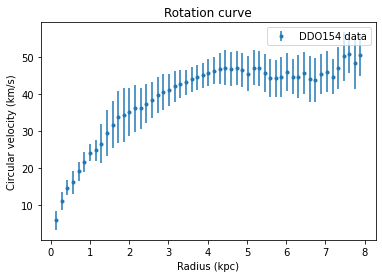

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data

# radius (kpc) 
radius = np.array([0.14, 0.29, 0.43, 0.57, 0.72, 0.86, 1.  , 1.15, 1.29, 1.44, 1.58,
                   1.72, 1.87, 2.01, 2.15, 2.3 , 2.44, 2.58, 2.73, 2.87, 3.01, 3.16,
                   3.3 , 3.44, 3.59, 3.73, 3.87, 4.02, 4.16, 4.31, 4.45, 4.59, 4.74,
                   4.88, 5.02, 5.17, 5.31, 5.45, 5.6 , 5.74, 5.88, 6.03, 6.17, 6.31,
                   6.46, 6.6 , 6.74, 6.89, 7.03, 7.18, 7.32, 7.46, 7.61, 7.75, 7.89])

# mean circular velocity v (km/s) 
mu = np.array([  5.77, 10.98, 14.65, 16.02, 19.01, 21.58, 24.06, 24.68, 26.55,
                29.44, 31.67, 33.67, 34.35, 35.06, 36.08, 36.16, 37.32, 38.39,
                39.8 , 40.48, 41.13, 42.01, 42.8 , 43.19, 43.91, 44.44, 45.02,
                45.79, 46.22, 46.81, 47.13, 46.73, 46.98, 46.54, 45.47, 47.11,
                46.96, 45.65, 44.21, 44.21, 44.63, 45.9 , 44.66, 44.7 , 45.64,
                44.01, 43.69, 45.49, 46.04, 44.67, 47.02, 50.15, 50.72, 48.32, 50.42])

# error for circular velocity v (km/s) 
sigma = np.array([2.59, 2.43, 2.15, 3.09, 2.62, 2.61, 2.34, 2.97, 5.39, 6.27, 6.34,
                  7.09, 7.31, 6.57, 6.35, 5.53, 5.24, 4.96, 4.85, 4.81, 4.33, 4.13,
                  3.78, 3.37, 3.41, 3.37, 3.43, 3.71, 3.65, 4.18, 4.72, 4.55, 4.53,
                  4.63, 4.68, 4.81, 4.71, 5.02, 5.16, 4.97, 5.49, 5.25, 4.78, 5.74,
                  5.77, 6.18, 5.95, 5.41, 5.58, 4.76, 5.66, 6.54, 5.12, 6.92, 5.61])
              
plt.errorbar(radius,mu,yerr=sigma,fmt='.',label='DDO154 data') 
plt.xlabel('Radius (kpc)')
plt.ylabel('Circular velocity (km/s)')
plt.title('Rotation curve')

plt.legend()
plt.show()


In [ ]:
# Your code for chi_sq(x,y) (from Exercise 11)


## <font color=#46769B>Part (a)</font>

One type of prior is simply to restrict the range of allowed range of the parameters in some way, for example, due to some other information we have. This might come from some other observations include in our analysis, or the model itself might require parameters to be in a certain range.

Choose a uniform prior for $x$ such that $P(x,y)$ is zero unless $0.5 < x < 0.55$, and perform all the steps described above.

In [7]:
import numpy as np
import matplotlib.pyplot as plt 

GN = 4.302e-6

# Note don't need normalizing constant A for MCMC
# A = 8445.264

def chi_sq(x,y):
    
    # Calculate a, Mtot
    a = 10**x
    Mtot = 10**y
    
    # Calculate predicted circular velocity
    M = Mtot*radius**3/(a+radius)**3
    f = np.sqrt(GN*M/radius)
    
    # return chi^2
    return np.sum((f-mu)**2/sigma**2)
def prior_a(x): 
  return np.where((0.5 < x and x < 0.55), (np.random.normal(0.525,0.002)), 0)

def P_a(x,y):
    return np.exp(-0.5*chi_sq(x,y))*prior_a(x)


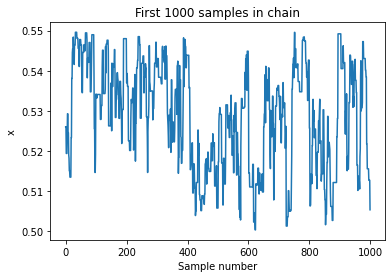

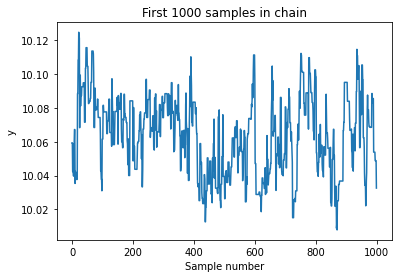

Acceptance fraction is 0.46802


In [20]:
num = 10**5

# Initialize chains
x_samples = [0.5260585214302914]
y_samples = [10.05937664106116]

# Widths for proposal PDF
sigma_x = 0.009
sigma_y = 0.02

# Count num_accept to compute acceptance ratio
# Initialize num_accept
num_accept = 0

# Run MCMC
for i in range(num-1):
    
    # Previous point
    x_old = x_samples[i]
    y_old = y_samples[i]
    
    # Sample new point
    x_new = np.random.normal(x_old,sigma_x)
    y_new = np.random.normal(y_old,sigma_y)
    
    # Acceptance ratio
    A = P_a(x_new,y_new)/P_a(x_old,y_old)
    
    # Accept/reject step
    if A > 1:
        x_samples.append(x_new)
        y_samples.append(y_new)
        num_accept += 1
    else:
        r = np.random.rand()
        if r < A:
            x_samples.append(x_new)
            y_samples.append(y_new)
            num_accept += 1
        else:
            x_samples.append(x_old)
            y_samples.append(y_old)

# Make plots
plt.plot(x_samples[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.show()

plt.plot(y_samples[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('y')
plt.show()

print("Acceptance fraction is", num_accept/num)

num_burnin = 1000

M_tot_samples_a = 10**np.array(y_samples[num_burnin:])

## <font color=#46769B>Part (b)</font>

A prior with a hard cutoff, as in Part (a), is not always the best option. Is it reasonable that $x=0.5001$ should be included in the samples, but $x=0.4999$ is not?

Another option is as follows. Choose a Gaussian prior on $x$ that is centered at $x = 0.525$ and has width $0.025$, and perform all the steps described above.

In [21]:
import numpy as np
import matplotlib.pyplot as plt 

GN = 4.302e-6

# Note don't need normalizing constant A for MCMC
# A = 8445.264

def chi_sq(x,y):
    
    # Calculate a, Mtot
    a = 10**x
    Mtot = 10**y
    
    # Calculate predicted circular velocity
    M = Mtot*radius**3/(a+radius)**3
    f = np.sqrt(GN*M/radius)
    
    # return chi^2
    return np.sum((f-mu)**2/sigma**2)
def prior_b(x): 
  return np.random.normal(0.525,0.025)

def P_b(x,y):
    return np.exp(-0.5*chi_sq(x,y))*prior_b(x)

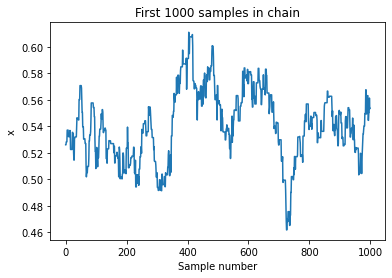

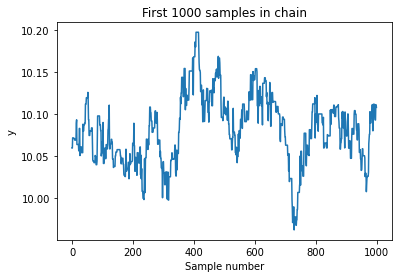

Acceptance fraction is 0.46015


In [24]:
num = 10**5

# Initialize chains
x_samples_b = [0.5260585214302914]
y_samples_b = [10.05937664106116]

# Widths for proposal PDF
sigma_x_b = 0.01
sigma_y_b = 0.025

# Count num_accept to compute acceptance ratio
# Initialize num_accept
num_accept_b = 0

# Run MCMC
for j in range(num-1):
    
    # Previous point
    x_old_b = x_samples_b[j]
    y_old_b = y_samples_b[j]
    
    # Sample new point
    x_new_b = np.random.normal(x_old_b,sigma_x_b)
    y_new_b = np.random.normal(y_old_b,sigma_y_b)
    
    # Acceptance ratio
    A_b = P_b(x_new_b,y_new_b)/P_b(x_old_b,y_old_b)
    
    # Accept/reject step
    if A_b > 1:
        x_samples_b.append(x_new_b)
        y_samples_b.append(y_new_b)
        num_accept_b += 1
    else:
        r = np.random.rand()
        if r < A_b:
            x_samples_b.append(x_new_b)
            y_samples_b.append(y_new_b)
            num_accept_b += 1
        else:
            x_samples_b.append(x_old_b)
            y_samples_b.append(y_old_b)

# Make plots
plt.plot(x_samples_b[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.show()

plt.plot(y_samples_b[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('y')
plt.show()

print("Acceptance fraction is", num_accept_b/num)

num_burnin = 1000

M_tot_samples_b = 10**np.array(y_samples_b[num_burnin:])

## <font color=#46769B>Part (c)</font>

Another type of prior comes from changing variables. Previously, we assumed uniform priors on $x,y$, that is, on the *logarithm* of $M_{\rm tot}$ and $a$. This is different than taking a uniform prior on $M_{\rm tot}$ and $a$ themselves.

We can translate one prior to another using the chain rule (see Exercise 5):
$$ P(y) = P(M_{\rm tot}) \,  \frac{dM_{\rm tot}}{dy} \, .$$
That is, if we adopted a uniform prior on $M_{\rm tot}$, where $P(M_{\rm tot}) = {\rm const}$, then this is *not* a uniform prior on $y$. Namely,
$$\frac{dM_{\rm tot}}{dy} = \log(10) \, M = \log(10) \, 10^{y} \, ,$$
where $\log$ denotes natural log, coded using `numpy.log`. 

Choose a prior on $y$ that is $10^y$, and perform all the steps described above.


In [27]:
import numpy as np
import matplotlib.pyplot as plt 

GN = 4.302e-6

# Note don't need normalizing constant A for MCMC
# A = 8445.264

def chi_sq(x,y):
    
    # Calculate a, Mtot
    a = 10**x
    Mtot = 10**y
    
    # Calculate predicted circular velocity
    M = Mtot*radius**3/(a+radius)**3
    f = np.sqrt(GN*M/radius)
    
    # return chi^2
    return np.sum((f-mu)**2/sigma**2)
def prior_c(y): 
  return 10**y

def P_c(x,y):
    return np.exp(-0.5*chi_sq(x,y))*prior_c(y)

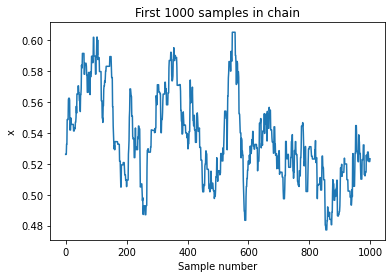

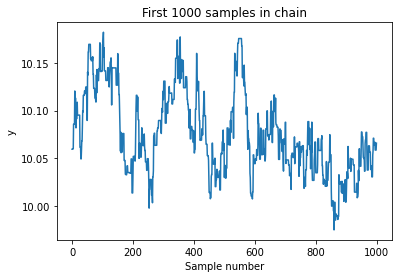

Acceptance fraction is 0.46138


In [28]:
num = 10**5

# Initialize chains
x_samples_c = [0.5260585214302914]
y_samples_c = [10.05937664106116]

# Widths for proposal PDF
sigma_x_c = 0.01
sigma_y_c = 0.025

# Count num_accept to compute acceptance ratio
# Initialize num_accept
num_accept_c = 0

# Run MCMC
for k in range(num-1):
    
    # Previous point
    x_old_c = x_samples_c[k]
    y_old_c = y_samples_c[k]
    
    # Sample new point
    x_new_c = np.random.normal(x_old_c,sigma_x_c)
    y_new_c = np.random.normal(y_old_c,sigma_y_c)
    
    # Acceptance ratio
    A_c = P_c(x_new_c,y_new_c)/P_c(x_old_c,y_old_c)
    
    # Accept/reject step
    if A_c > 1:
        x_samples_c.append(x_new_c)
        y_samples_c.append(y_new_c)
        num_accept_c += 1
    else:
        r = np.random.rand()
        if r < A_c:
            x_samples_c.append(x_new_c)
            y_samples_c.append(y_new_c)
            num_accept_c += 1
        else:
            x_samples_c.append(x_old_c)
            y_samples_c.append(y_old_c)

# Make plots
plt.plot(x_samples_c[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.show()

plt.plot(y_samples_c[:1000])
plt.title('First 1000 samples in chain')
plt.xlabel('Sample number')
plt.ylabel('y')
plt.show()

print("Acceptance fraction is", num_accept_c/num)

num_burnin = 1000

M_tot_samples_c = 10**np.array(y_samples_c[num_burnin:])

## <font color=#46769B>Part (d)</font>

Make a plot showing 1D marginalized histograms for your $M_{\rm tot}$ samples from parts (a), (b), and (c). Show all three samples on the same plot, and choose an appropriate `bins` so that your plot looks good.

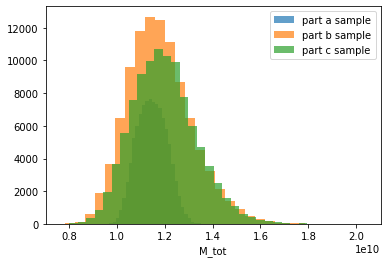

Mean and standard deviation for M_tot are 11748243866.483236 1170759174.1762507


In [33]:
plt.hist(M_tot_samples_a,bins=30, label = 'part a sample', alpha = 0.7)
plt.hist(M_tot_samples_b,bins=30, label = 'part b sample', alpha = 0.7)
plt.hist(M_tot_samples_c,bins=30, label = 'part c sample', alpha = 0.7)
plt.legend()
plt.xlabel('M_tot')
plt.show()

M_tot_samples = [M_tot_samples_a, M_tot_samples_b, M_tot_samples_c]
print("Mean and standard deviation for M_tot are", np.mean(M_tot_samples), np.std(M_tot_samples))
